In [1]:
from random import sample, seed
import numpy as np 
import pandas as pd
from joblib import dump, load

from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, Draw
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Visualization
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

from tqdm import tqdm
tqdm.pandas()

np.random.seed(42)
seed(42)

### Data pre-processing

Import tested building blocks and active compounds

In [2]:
tested_arenes = pd.read_csv('data/tested_arenes.csv', dtype={'ID': str, 'SMILES': str})
tested_amines = pd.read_csv('data/tested_amines.csv', dtype={'ID': str, 'SMILES': str})
tested_aldehydes = pd.read_csv('data/tested_aldehydes.csv', dtype={'ID': str, 'SMILES': str})

actives = pd.read_csv('data/actives.csv', dtype={'ID': str, 'MIC': float, 'CC50': float, 'HC10': float})
actives['IsActive'] = 1

Import library building blocks

In [3]:
library_arenes = pd.read_csv('data/library_arenes.csv', dtype={'ID': str, 'SMILES': str})
library_amines = pd.read_csv('data/library_amines.csv', dtype={'ID': str, 'SMILES': str})
library_aldehydes = pd.read_csv('data/library_aldehydes.csv', dtype={'ID': str, 'SMILES': str})

Generate rdkit.mol object for each building block

In [4]:
tested_arenes['MOL'] = tested_arenes.SMILES.apply(Chem.MolFromSmiles)
tested_amines['MOL'] = tested_amines.SMILES.apply(Chem.MolFromSmiles)
tested_aldehydes['MOL'] = tested_aldehydes.SMILES.apply(Chem.MolFromSmiles)

library_arenes['MOL'] = library_arenes.SMILES.apply(Chem.MolFromSmiles)
library_amines['MOL'] = library_amines.SMILES.apply(Chem.MolFromSmiles)
library_aldehydes['MOL'] = library_aldehydes.SMILES.apply(Chem.MolFromSmiles)

Calculate ECFP4 fingerprint of each building block

In [5]:
def calc_ecfp4(mol):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=512)
    arr = np.zeros((0,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp,arr)
    return arr

tested_arenes['ECFP4'] = tested_arenes.MOL.apply(calc_ecfp4)
tested_amines['ECFP4'] = tested_amines.MOL.apply(calc_ecfp4)
tested_aldehydes['ECFP4'] = tested_aldehydes.MOL.apply(calc_ecfp4)

library_arenes['ECFP4'] = library_arenes.MOL.apply(calc_ecfp4)
library_amines['ECFP4'] = library_amines.MOL.apply(calc_ecfp4)
library_aldehydes['ECFP4'] = library_aldehydes.MOL.apply(calc_ecfp4)

Generate combinatorial library of tested compounds

In [6]:
tested_id = []
tested_smiles = []
tested_ecfp4 = []

for i in range(len(tested_arenes)):
    for j in range(len(tested_amines)):
        for k in range(len(tested_aldehydes)):
            tested_id.append(f'{tested_arenes.ID.iloc[i]}{tested_amines.ID.iloc[j]}{tested_aldehydes.ID.iloc[k]}')
            tested_smiles.append(f'{tested_arenes.SMILES.iloc[i]}.{tested_amines.SMILES.iloc[j]}.{tested_aldehydes.SMILES.iloc[k]}')
            tested_ecfp4.append(np.sum([tested_arenes.ECFP4.iloc[i], tested_amines.ECFP4.iloc[j], tested_aldehydes.ECFP4.iloc[k]], axis=0)) # ECFPs are summed

df_tested = pd.DataFrame(list(zip(tested_id, tested_smiles, tested_ecfp4)), columns=['ID', 'SMILES', 'ECFP4'])

### Models

Add activity information to dataframe

In [7]:
df_train = df_tested.copy()
actives_id = actives.ID.values.tolist()

def IsActive(id, id_list):
    if id in id_list:
        return 1
    else:
        return 0

df_train['IsActive'] = df_train.ID.apply(lambda x: IsActive(x, actives_id))

X = np.array(df_train.ECFP4.values.tolist())
y = np.array(df_train.IsActive.values.tolist())
y_scrambled = np.array(sample(list(y), len(y)))

#### Random Forest

In [8]:
rf = RandomForestClassifier(max_depth=5, random_state=42)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

Mean accuracy: 0.94 ± 0.02
Mean precision: 0.0 ± 0.0
Mean recall: 0.0 ± 0.0
Mean F1: 0.0 ± 0.0


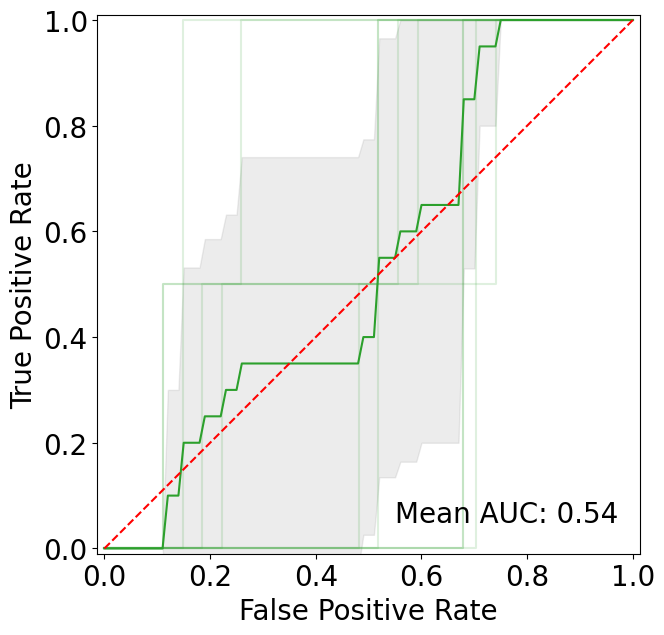

In [9]:
# Store AUCs and TPRs
aucs = []
tprs = []
base_fpr = np.linspace(0, 1, 101)

# Store accuracy, precision, recall and f1 scores
accuracies = []
precisions = []
recalls = []
f1s = []

# Initialize figure
plt.figure(figsize=(7, 7))
plt.axes().set_aspect('equal', 'datalim')

# Loop through cross-validation and plot ROC curves, calculate AUCs and TPRs and store scores
for i, (train, test) in enumerate(cv.split(X, y_scrambled)):
    # Fit model to data
    rf.fit(X[train], y_scrambled[train])

    # Predict values
    y_score = rf.predict_proba(X[test])
    y_pred = rf.predict(X[test])

    # Determine metrics
    fpr, tpr, _ = roc_curve(y_scrambled[test], y_score[:, 1])
    accuracies.append(accuracy_score(y_scrambled[test], y_pred))
    precisions.append(precision_score(y_scrambled[test], y_pred, zero_division=0))
    recalls.append(recall_score(y_scrambled[test], y_pred, zero_division=0))
    f1s.append(f1_score(y_scrambled[test], y_pred, zero_division=0))
    
    # Plot ROC curve
    plt.plot(fpr, tpr, 'tab:green', alpha=0.15)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0

    # Store AUCs and TPRs
    tprs.append(tpr)
    aucs.append(roc_auc_score(y_scrambled[test], y_score[:, 1]))

# Determine mean metrics
tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)
tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

mean_precision = np.mean(precisions)
std_precision = np.std(precisions)

mean_recall = np.mean(recalls)
std_recall = np.std(recalls)

mean_f1 = np.mean(f1s)
std_f1 = np.std(f1s)

# Plot mean ROC curve and save figure
plt.plot(base_fpr, mean_tprs, 'tab:green')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.15)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.text(0.55, 0.05, f'Mean AUC: {round(np.mean(aucs), 2)}')
plt.savefig('plots/rf_scrambled.pdf')

# Print mean metrics
print(f'Mean accuracy: {round(mean_accuracy, 2)} ± {round(std_accuracy, 2)}')
print(f'Mean precision: {round(mean_precision, 2)} ± {round(std_precision, 2)}')
print(f'Mean recall: {round(mean_recall, 2)} ± {round(std_recall, 2)}')
print(f'Mean F1: {round(mean_f1, 2)} ± {round(std_f1, 2)}')

Mean accuracy: 0.94 ± 0.02
Mean precision: 0.1 ± 0.3
Mean recall: 0.05 ± 0.15
Mean F1: 0.07 ± 0.2


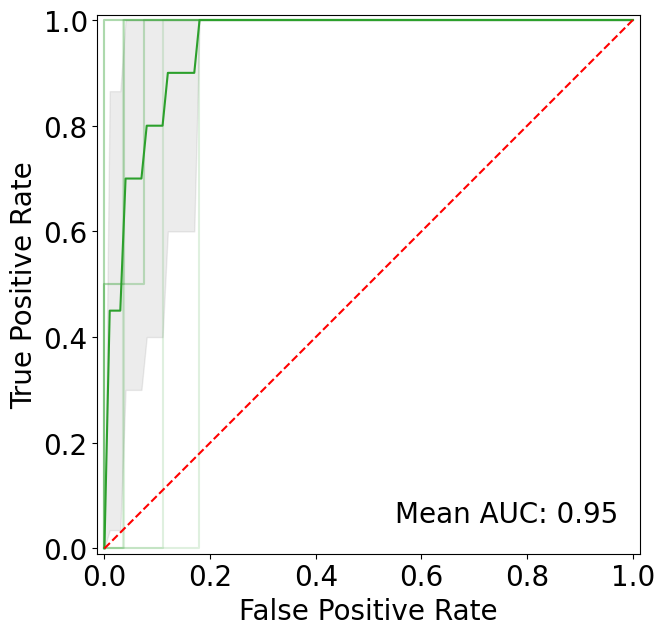

In [10]:
# Store AUCs and TPRs
aucs = []
tprs = []
base_fpr = np.linspace(0, 1, 101)

# Store accuracy, precision, recall and f1 scores
accuracies = []
precisions = []
recalls = []
f1s = []

# Initialize figure
plt.figure(figsize=(7, 7))
plt.axes().set_aspect('equal', 'datalim')

# Loop through cross-validation and plot ROC curves, calculate AUCs and TPRs and store scores
for i, (train, test) in enumerate(cv.split(X, y)):
    # Fit model to data
    rf.fit(X[train], y[train])

    # Predict values
    y_score = rf.predict_proba(X[test])
    y_pred = rf.predict(X[test])

    # Determine metrics
    fpr, tpr, _ = roc_curve(y[test], y_score[:, 1])
    accuracies.append(accuracy_score(y[test], y_pred))
    precisions.append(precision_score(y[test], y_pred, zero_division=0))
    recalls.append(recall_score(y[test], y_pred, zero_division=0))
    f1s.append(f1_score(y[test], y_pred, zero_division=0))
    
    # Plot ROC curve
    plt.plot(fpr, tpr, 'tab:green', alpha=0.15)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0

    # Store AUCs and TPRs
    tprs.append(tpr)
    aucs.append(roc_auc_score(y[test], y_score[:, 1]))

# Determine mean metrics
tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)
tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

mean_precision = np.mean(precisions)
std_precision = np.std(precisions)

mean_recall = np.mean(recalls)
std_recall = np.std(recalls)

mean_f1 = np.mean(f1s)
std_f1 = np.std(f1s)

# Plot mean ROC curve and save figure
plt.plot(base_fpr, mean_tprs, 'tab:green')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.15)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.text(0.55, 0.05, f'Mean AUC: {round(np.mean(aucs), 2)}')
plt.savefig('plots/rf.pdf')

# Print mean metrics
print(f'Mean accuracy: {round(mean_accuracy, 2)} ± {round(std_accuracy, 2)}')
print(f'Mean precision: {round(mean_precision, 2)} ± {round(std_precision, 2)}')
print(f'Mean recall: {round(mean_recall, 2)} ± {round(std_recall, 2)}')
print(f'Mean F1: {round(mean_f1, 2)} ± {round(std_f1, 2)}')

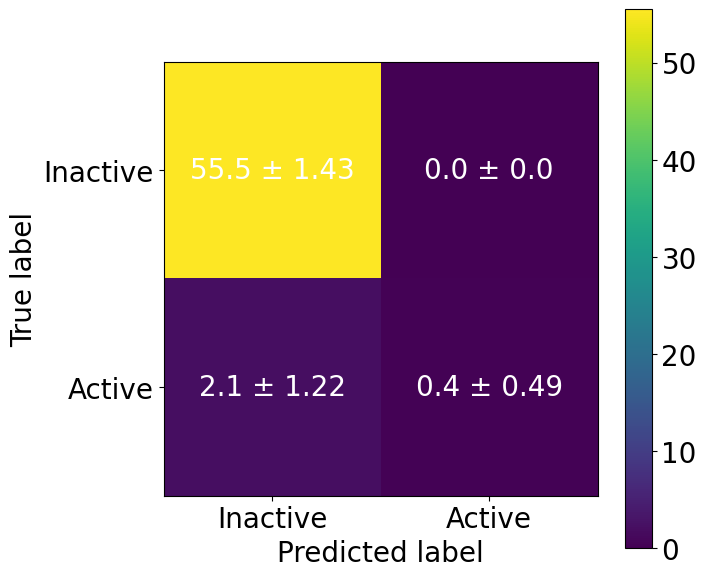

In [11]:
confusion_matrices = []
for i in range(0, 10):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

    # Fit model to data
    rf.fit(X_train, y_train)

    # Predict values
    y_pred = rf.predict(X_test)

    # Determine confusion matrix
    conf_mat = confusion_matrix(y_test, y_pred)

    # Store confusion matrix
    confusion_matrices.append(conf_mat)

# Determine mean confusion matrix
mean_confusion = np.round(np.mean(confusion_matrices, axis=0), decimals=2)
std_confusion = np.round(np.std(confusion_matrices, axis=0), decimals=2)

# Plot confusion matrix
plt.figure(figsize=(7, 7))
plt.axes().set_aspect('equal')
plt.imshow(mean_confusion, cmap='viridis')
for i in range(2):
    for j in range(2):
        plt.text(j, i, f'{mean_confusion[i, j]} ± {std_confusion[i, j]}', ha='center', va='center', color='w')
plt.colorbar()
plt.xticks([0, 1], ['Inactive', 'Active'])
plt.yticks([0, 1], ['Inactive', 'Active'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.savefig('plots/rf_confusion_matrix.pdf', bbox_inches='tight')

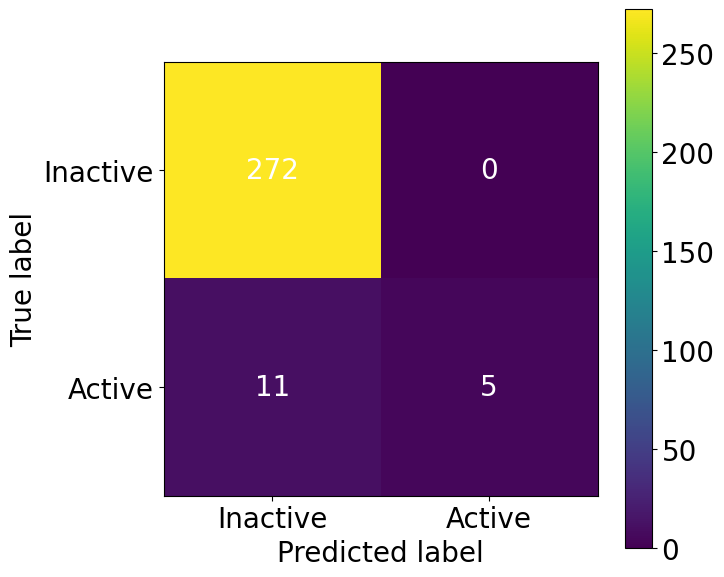

In [12]:
rf.fit(X, y)

confusion_mat = confusion_matrix(y, rf.predict(X))

plt.figure(figsize=(7, 7))
plt.axes().set_aspect('equal')
plt.imshow(confusion_mat, cmap='viridis')
for i in range(2):
    for j in range(2):
        plt.text(j, i, int(confusion_mat[i, j]), ha='center', va='center', color='w')
plt.colorbar()
plt.xticks([0, 1], ['Inactive', 'Active'])
plt.yticks([0, 1], ['Inactive', 'Active'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.savefig('plots/rf_confusion_matrix_on_training.pdf', bbox_inches='tight')

#### Naive Bayes

In [13]:
nb = GaussianNB()
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

Mean accuracy: 0.41 ± 0.09
Mean precision: 0.06 ± 0.04
Mean recall: 0.7 ± 0.4
Mean F1: 0.11 ± 0.07


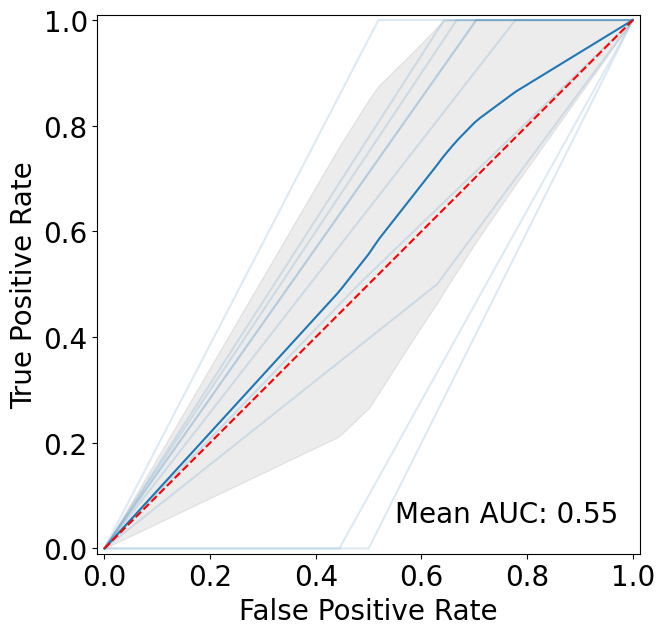

In [14]:
# Store AUCs and TPRs
aucs = []
tprs = []
base_fpr = np.linspace(0, 1, 101)

# Store accuracy, precision, recall and f1 scores
accuracies = []
precisions = []
recalls = []
f1s = []

# Initialize figure
plt.figure(figsize=(7, 7))
plt.axes().set_aspect('equal', 'datalim')

# Loop through cross-validation and plot ROC curves, calculate AUCs and TPRs and store scores
for i, (train, test) in enumerate(cv.split(X, y_scrambled)):
    # Fit model to data
    nb.fit(X[train], y_scrambled[train])

    # Predict values
    y_score = nb.predict_proba(X[test])
    y_pred = nb.predict(X[test])

    # Determine metrics
    fpr, tpr, _ = roc_curve(y_scrambled[test], y_score[:, 1])
    accuracies.append(accuracy_score(y_scrambled[test], y_pred))
    precisions.append(precision_score(y_scrambled[test], y_pred, zero_division=0))
    recalls.append(recall_score(y_scrambled[test], y_pred, zero_division=0))
    f1s.append(f1_score(y_scrambled[test], y_pred, zero_division=0))
    
    # Plot ROC curve
    plt.plot(fpr, tpr, 'tab:blue', alpha=0.15)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0

    # Store AUCs and TPRs
    tprs.append(tpr)
    aucs.append(roc_auc_score(y_scrambled[test], y_score[:, 1]))

# Determine mean metrics
tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)
tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

mean_precision = np.mean(precisions)
std_precision = np.std(precisions)

mean_recall = np.mean(recalls)
std_recall = np.std(recalls)

mean_f1 = np.mean(f1s)
std_f1 = np.std(f1s)

# Plot mean ROC curve and save figure
plt.plot(base_fpr, mean_tprs, 'tab:blue')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.15)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.text(0.55, 0.05, f'Mean AUC: {round(np.mean(aucs), 2)}')
plt.savefig('plots/nb_scrambled.pdf')

# Print mean metrics
print(f'Mean accuracy: {round(mean_accuracy, 2)} ± {round(std_accuracy, 2)}')
print(f'Mean precision: {round(mean_precision, 2)} ± {round(std_precision, 2)}')
print(f'Mean recall: {round(mean_recall, 2)} ± {round(std_recall, 2)}')
print(f'Mean F1: {round(mean_f1, 2)} ± {round(std_f1, 2)}')

Mean accuracy: 0.77 ± 0.04
Mean precision: 0.15 ± 0.08
Mean recall: 0.65 ± 0.39
Mean F1: 0.23 ± 0.13


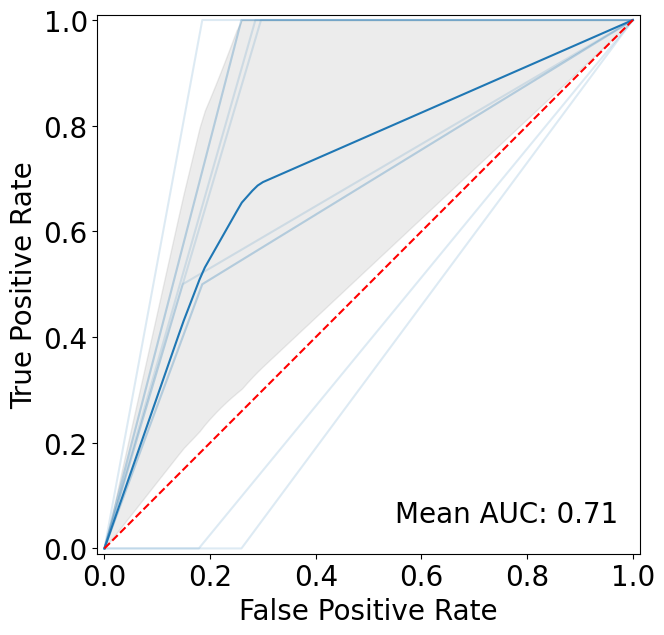

In [15]:
# Store AUCs and TPRs
aucs = []
tprs = []
base_fpr = np.linspace(0, 1, 101)

# Store accuracy, precision, recall and f1 scores
accuracies = []
precisions = []
recalls = []
f1s = []

# Initialize figure
plt.figure(figsize=(7, 7))
plt.axes().set_aspect('equal', 'datalim')

# Loop through cross-validation and plot ROC curves, calculate AUCs and TPRs and store scores
for i, (train, test) in enumerate(cv.split(X, y)):
    # Fit model to data
    nb.fit(X[train], y[train])

    # Predict values
    y_score = nb.predict_proba(X[test])
    y_pred = nb.predict(X[test])

    # Determine metrics
    fpr, tpr, _ = roc_curve(y[test], y_score[:, 1])
    accuracies.append(accuracy_score(y[test], y_pred))
    precisions.append(precision_score(y[test], y_pred, zero_division=0))
    recalls.append(recall_score(y[test], y_pred, zero_division=0))
    f1s.append(f1_score(y[test], y_pred, zero_division=0))
    
    # Plot ROC curve
    plt.plot(fpr, tpr, 'tab:blue', alpha=0.15)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0

    # Store AUCs and TPRs
    tprs.append(tpr)
    aucs.append(roc_auc_score(y[test], y_score[:, 1]))

# Determine mean metrics
tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)
tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

mean_precision = np.mean(precisions)
std_precision = np.std(precisions)

mean_recall = np.mean(recalls)
std_recall = np.std(recalls)

mean_f1 = np.mean(f1s)
std_f1 = np.std(f1s)

# Plot mean ROC curve and save figure
plt.plot(base_fpr, mean_tprs, 'tab:blue')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.15)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.text(0.55, 0.05, f'Mean AUC: {round(np.mean(aucs), 2)}')
plt.savefig('plots/nb.pdf')

# Print mean metrics
print(f'Mean accuracy: {round(mean_accuracy, 2)} ± {round(std_accuracy, 2)}')
print(f'Mean precision: {round(mean_precision, 2)} ± {round(std_precision, 2)}')
print(f'Mean recall: {round(mean_recall, 2)} ± {round(std_recall, 2)}')
print(f'Mean F1: {round(mean_f1, 2)} ± {round(std_f1, 2)}')

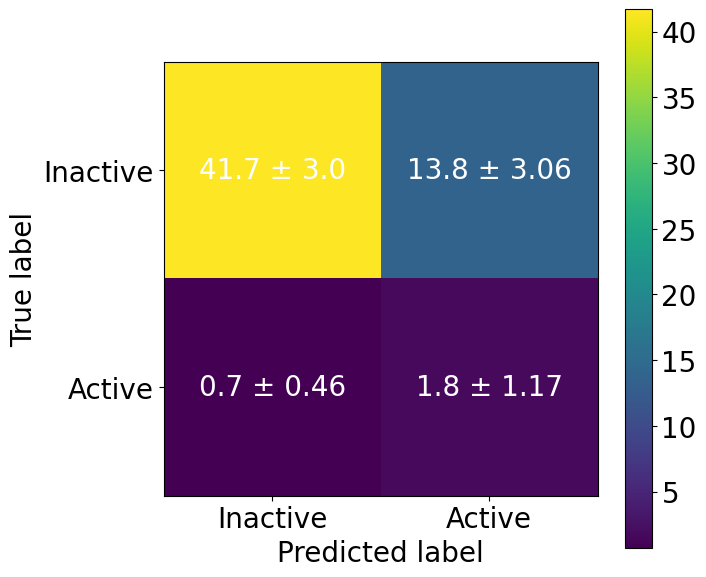

In [16]:
confusion_matrices = []
for i in range(0, 10):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

    # Fit model to data
    nb.fit(X_train, y_train)

    # Predict values
    y_pred = nb.predict(X_test)

    # Determine confusion matrix
    conf_mat = confusion_matrix(y_test, y_pred)

    # Store confusion matrix
    confusion_matrices.append(conf_mat)

# Determine mean confusion matrix
mean_confusion = np.round(np.mean(confusion_matrices, axis=0), decimals=2)
std_confusion = np.round(np.std(confusion_matrices, axis=0), decimals=2)

# Plot confusion matrix
plt.figure(figsize=(7, 7))
plt.axes().set_aspect('equal')
plt.imshow(mean_confusion, cmap='viridis')
for i in range(2):
    for j in range(2):
        plt.text(j, i, f'{mean_confusion[i, j]} ± {std_confusion[i, j]}', ha='center', va='center', color='w')
plt.colorbar()
plt.xticks([0, 1], ['Inactive', 'Active'])
plt.yticks([0, 1], ['Inactive', 'Active'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.savefig('plots/nb_confusion_matrix.pdf', bbox_inches='tight')

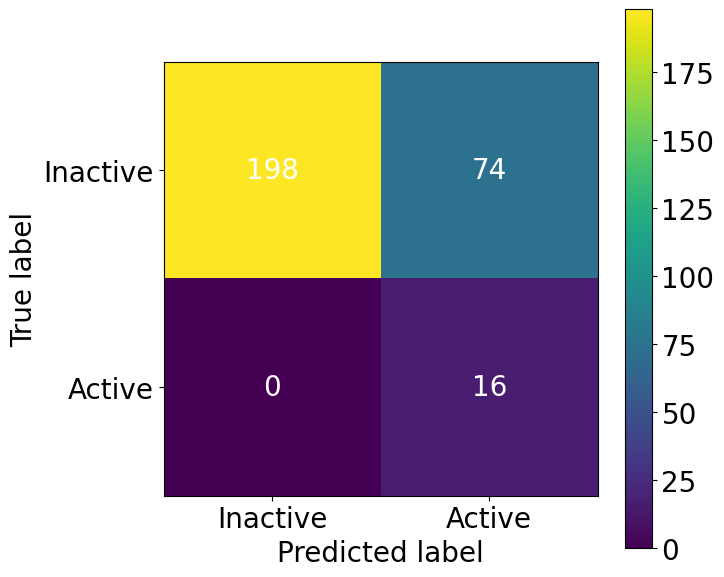

In [17]:
nb.fit(X, y)

confusion_mat = confusion_matrix(y, nb.predict(X))

plt.figure(figsize=(7, 7))
plt.axes().set_aspect('equal')
plt.imshow(confusion_mat, cmap='viridis')
for i in range(2):
    for j in range(2):
        plt.text(j, i, int(confusion_mat[i, j]), ha='center', va='center', color='w')
plt.colorbar()
plt.xticks([0, 1], ['Inactive', 'Active'])
plt.yticks([0, 1], ['Inactive', 'Active'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.savefig('plots/nb_confusion_matrix_on_training.pdf', bbox_inches='tight')

#### Support Vector Machine

In [18]:
svm = SVC(kernel='linear', random_state=42, probability=True)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

Mean accuracy: 0.94 ± 0.02
Mean precision: 0.0 ± 0.0
Mean recall: 0.0 ± 0.0
Mean F1: 0.0 ± 0.0


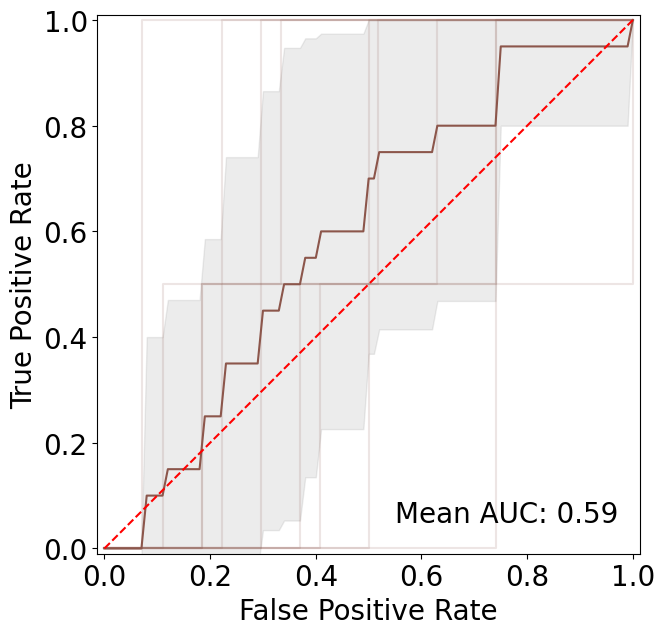

In [19]:
# Store AUCs and TPRs
aucs = []
tprs = []
base_fpr = np.linspace(0, 1, 101)

# Store accuracy, precision, recall and f1 scores
accuracies = []
precisions = []
recalls = []
f1s = []

# Initialize figure
plt.figure(figsize=(7, 7))
plt.axes().set_aspect('equal', 'datalim')

# Loop through cross-validation and plot ROC curves, calculate AUCs and TPRs and store scores
for i, (train, test) in enumerate(cv.split(X, y_scrambled)):
    # Fit model to data
    svm.fit(X[train], y_scrambled[train])

    # Predict values
    y_score = svm.predict_proba(X[test])
    y_pred = svm.predict(X[test])

    # Determine metrics
    fpr, tpr, _ = roc_curve(y_scrambled[test], y_score[:, 1])
    accuracies.append(accuracy_score(y_scrambled[test], y_pred))
    precisions.append(precision_score(y_scrambled[test], y_pred, zero_division=0))
    recalls.append(recall_score(y_scrambled[test], y_pred, zero_division=0))
    f1s.append(f1_score(y_scrambled[test], y_pred, zero_division=0))
    
    # Plot ROC curve
    plt.plot(fpr, tpr, 'tab:brown', alpha=0.15)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0

    # Store AUCs and TPRs
    tprs.append(tpr)
    aucs.append(roc_auc_score(y_scrambled[test], y_score[:, 1]))

# Determine mean metrics
tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)
tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

mean_precision = np.mean(precisions)
std_precision = np.std(precisions)

mean_recall = np.mean(recalls)
std_recall = np.std(recalls)

mean_f1 = np.mean(f1s)
std_f1 = np.std(f1s)

# Plot mean ROC curve and save figure
plt.plot(base_fpr, mean_tprs, 'tab:brown')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.15)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.text(0.55, 0.05, f'Mean AUC: {round(np.mean(aucs), 2)}')
plt.savefig('plots/svm_scrambled.pdf')

# Print mean metrics
print(f'Mean accuracy: {round(mean_accuracy, 2)} ± {round(std_accuracy, 2)}')
print(f'Mean precision: {round(mean_precision, 2)} ± {round(std_precision, 2)}')
print(f'Mean recall: {round(mean_recall, 2)} ± {round(std_recall, 2)}')
print(f'Mean F1: {round(mean_f1, 2)} ± {round(std_f1, 2)}')

Mean accuracy: 0.93 ± 0.03
Mean precision: 0.43 ± 0.35
Mean recall: 0.5 ± 0.39
Mean F1: 0.42 ± 0.28


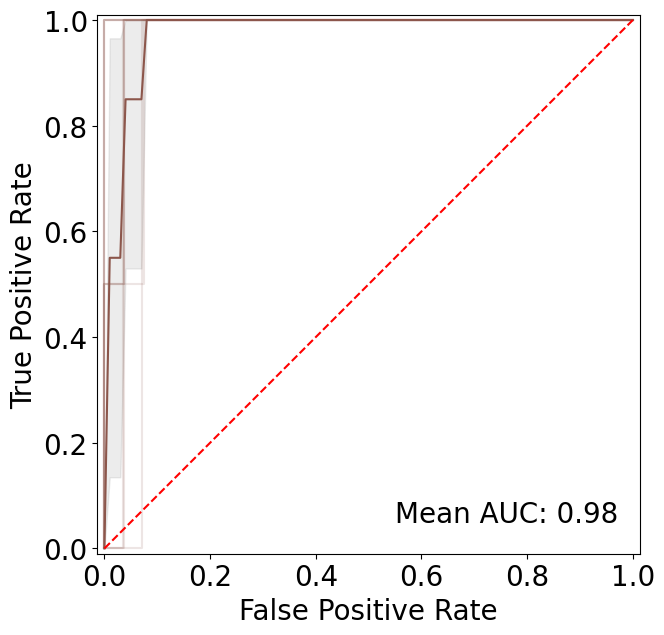

In [20]:
# Store AUCs and TPRs
aucs = []
tprs = []
base_fpr = np.linspace(0, 1, 101)

# Store accuracy, precision, recall and f1 scores
accuracies = []
precisions = []
recalls = []
f1s = []

# Initialize figure
plt.figure(figsize=(7, 7))
plt.axes().set_aspect('equal', 'datalim')

# Loop through cross-validation and plot ROC curves, calculate AUCs and TPRs and store scores
for i, (train, test) in enumerate(cv.split(X, y)):
    # Fit model to data
    svm.fit(X[train], y[train])

    # Predict values
    y_score = svm.predict_proba(X[test])
    y_pred = svm.predict(X[test])

    # Determine metrics
    fpr, tpr, _ = roc_curve(y[test], y_score[:, 1])
    accuracies.append(accuracy_score(y[test], y_pred))
    precisions.append(precision_score(y[test], y_pred, zero_division=0))
    recalls.append(recall_score(y[test], y_pred, zero_division=0))
    f1s.append(f1_score(y[test], y_pred, zero_division=0))
    
    # Plot ROC curve
    plt.plot(fpr, tpr, 'tab:brown', alpha=0.15)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0

    # Store AUCs and TPRs
    tprs.append(tpr)
    aucs.append(roc_auc_score(y[test], y_score[:, 1]))

# Determine mean metrics
tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)
tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

mean_precision = np.mean(precisions)
std_precision = np.std(precisions)

mean_recall = np.mean(recalls)
std_recall = np.std(recalls)

mean_f1 = np.mean(f1s)
std_f1 = np.std(f1s)

# Plot mean ROC curve and save figure
plt.plot(base_fpr, mean_tprs, 'tab:brown')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.15)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.text(0.55, 0.05, f'Mean AUC: {round(np.mean(aucs), 2)}')
plt.savefig('plots/svm.pdf')

# Print mean metrics
print(f'Mean accuracy: {round(mean_accuracy, 2)} ± {round(std_accuracy, 2)}')
print(f'Mean precision: {round(mean_precision, 2)} ± {round(std_precision, 2)}')
print(f'Mean recall: {round(mean_recall, 2)} ± {round(std_recall, 2)}')
print(f'Mean F1: {round(mean_f1, 2)} ± {round(std_f1, 2)}')

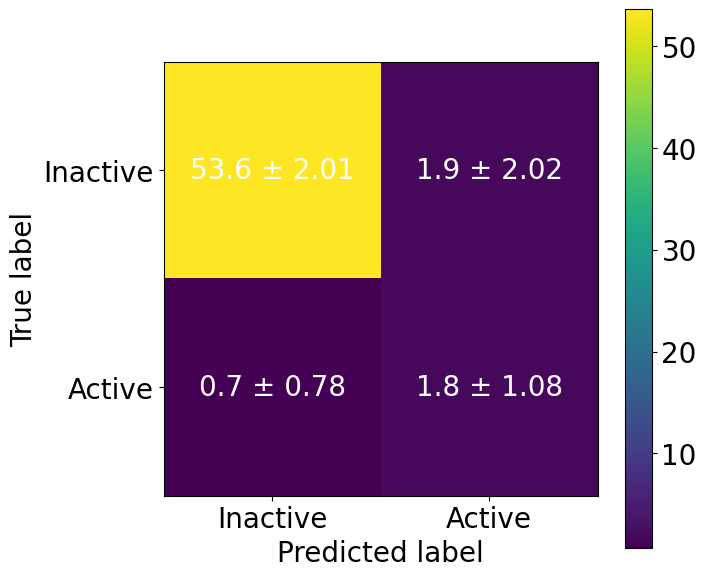

In [21]:
confusion_matrices = []
for i in range(0, 10):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

    # Fit model to data
    svm.fit(X_train, y_train)

    # Predict values
    y_pred = svm.predict(X_test)

    # Determine confusion matrix
    conf_mat = confusion_matrix(y_test, y_pred)

    # Store confusion matrix
    confusion_matrices.append(conf_mat)

# Determine mean confusion matrix
mean_confusion = np.round(np.mean(confusion_matrices, axis=0), decimals=2)
std_confusion = np.round(np.std(confusion_matrices, axis=0), decimals=2)

# Plot confusion matrix
plt.figure(figsize=(7, 7))
plt.axes().set_aspect('equal')
plt.imshow(mean_confusion, cmap='viridis')
for i in range(2):
    for j in range(2):
        plt.text(j, i, f'{mean_confusion[i, j]} ± {std_confusion[i, j]}', ha='center', va='center', color='w')
plt.colorbar()
plt.xticks([0, 1], ['Inactive', 'Active'])
plt.yticks([0, 1], ['Inactive', 'Active'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.savefig('plots/svm_confusion_matrix.pdf', bbox_inches='tight')

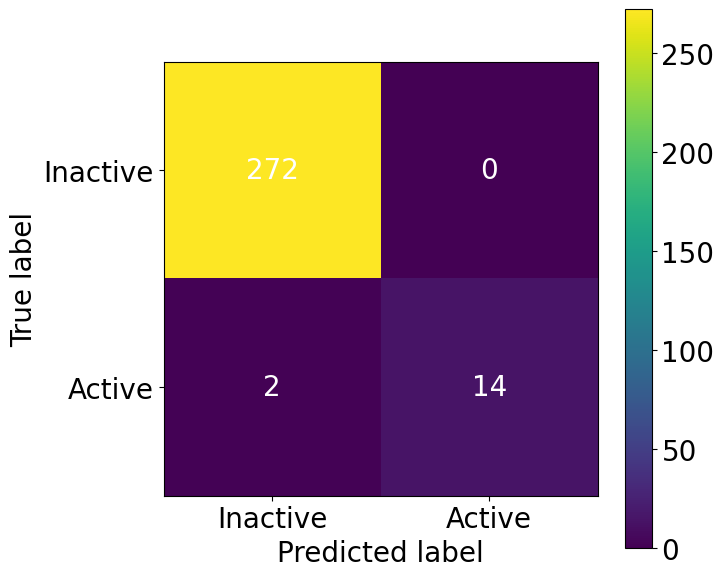

In [22]:
svm.fit(X, y)

confusion_mat = confusion_matrix(y, svm.predict(X))

plt.figure(figsize=(7, 7))
plt.axes().set_aspect('equal')
plt.imshow(confusion_mat, cmap='viridis')
for i in range(2):
    for j in range(2):
        plt.text(j, i, int(confusion_mat[i, j]), ha='center', va='center', color='w')
plt.colorbar()
plt.xticks([0, 1], ['Inactive', 'Active'])
plt.yticks([0, 1], ['Inactive', 'Active'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.savefig('plots/svm_confusion_matrix_on_training.pdf', bbox_inches='tight')

Analyse SVM coefficients and feature importance

In [23]:
svm.fit(X, y)

svm_coefficients = svm.coef_
indices_pos = np.argsort(svm_coefficients)[0][-15:] # 10 highest coefficients
indices_neg = np.argsort(svm_coefficients)[0][:15] # 10 lowest coefficients

Substructures linked to top 10 features with a positive coefficient

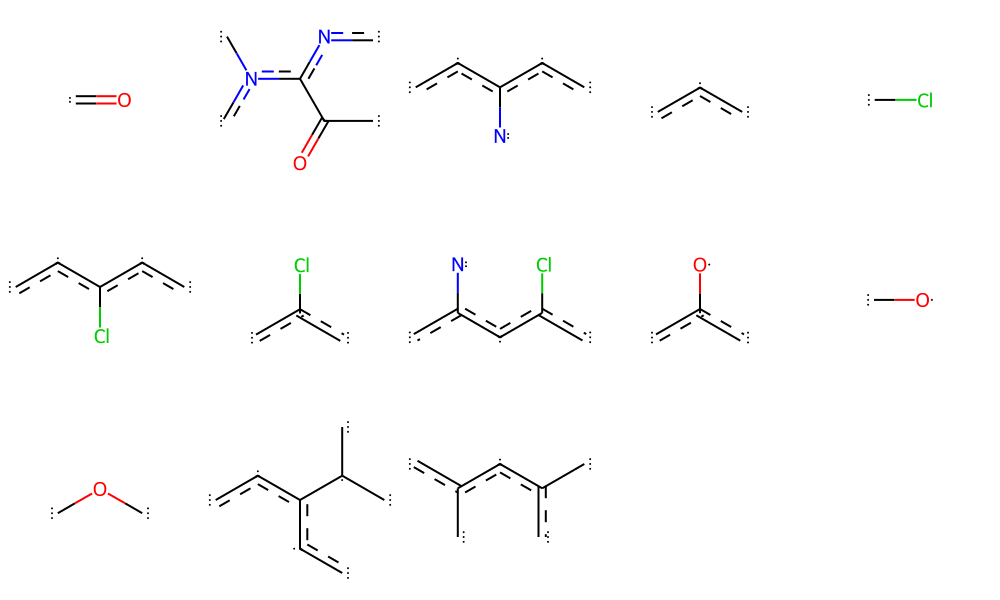

In [24]:
smiles_list = df_tested['SMILES'].values.tolist()
mols_list = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]

substructs = []
for mol in mols_list:
    bi = {}
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=512, bitInfo=bi)
    for bit in indices_pos:
        if bit in bi.keys():
            atom_idx, radius = bi[bit][0]
            env = Chem.FindAtomEnvironmentOfRadiusN(mol, radius, atom_idx)
            submol = Chem.MolToSmarts(Chem.PathToSubmol(mol, env))
            if submol not in substructs and submol != '':
                substructs.append(submol)
        else:
            continue

# Draw substructures in grid
mols = [Chem.MolFromSmiles(substruct) for substruct in substructs]
Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200, 200), useSVG=True)

Substructures linked to top 10 features with a negative coefficient

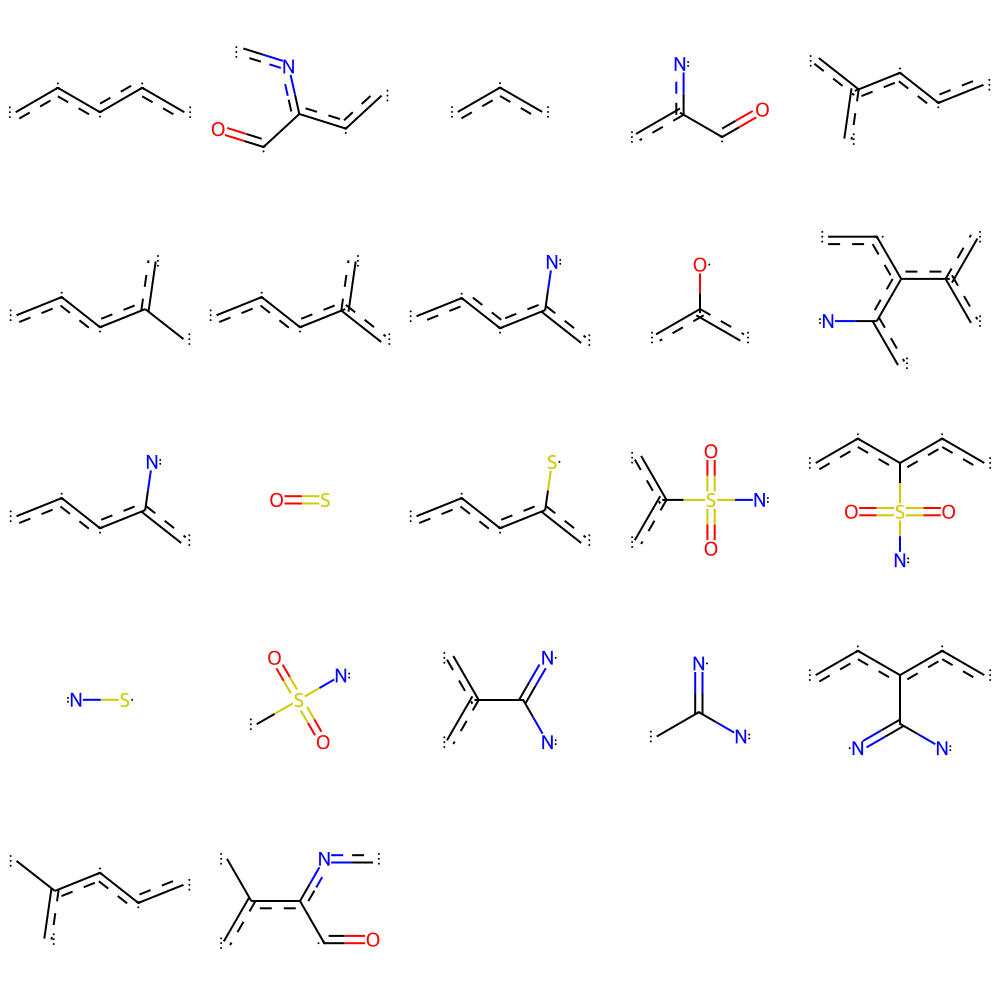

In [25]:
substructs = []
for mol in mols_list:
    bi = {}
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=512, bitInfo=bi)
    for bit in indices_neg:
        if bit in bi.keys():
            atom_idx, radius = bi[bit][0]
            env = Chem.FindAtomEnvironmentOfRadiusN(mol, radius, atom_idx)
            submol = Chem.MolToSmarts(Chem.PathToSubmol(mol, env))
            if submol not in substructs and submol != '':
                substructs.append(submol)
        else:
            continue

# Draw substructures in grid
mols = [Chem.MolFromSmiles(substruct) for substruct in substructs]
Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200, 200), useSVG=True)

#### Multi-layer Perceptron

In [26]:
mlp = MLPClassifier(alpha=1, max_iter=1000, hidden_layer_sizes=(10, 10, 2), random_state=42)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

Mean accuracy: 0.94 ± 0.02
Mean precision: 0.0 ± 0.0
Mean recall: 0.0 ± 0.0
Mean F1: 0.0 ± 0.0


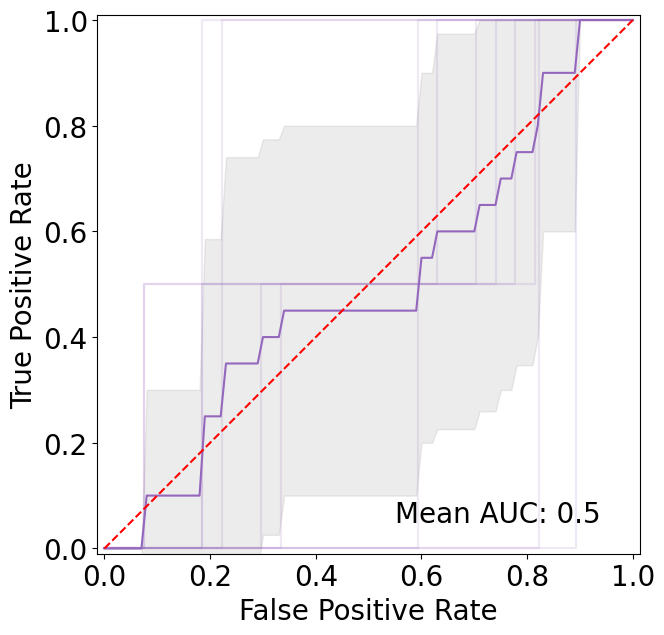

In [27]:
# Store AUCs and TPRs
aucs = []
tprs = []
base_fpr = np.linspace(0, 1, 101)

# Store accuracy, precision, recall and f1 scores
accuracies = []
precisions = []
recalls = []
f1s = []

# Initialize figure
plt.figure(figsize=(7, 7))
plt.axes().set_aspect('equal', 'datalim')

# Loop through cross-validation and plot ROC curves, calculate AUCs and TPRs and store scores
for i, (train, test) in enumerate(cv.split(X, y_scrambled)):
    # Fit model to data
    mlp.fit(X[train], y_scrambled[train])

    # Predict values
    y_score = mlp.predict_proba(X[test])
    y_pred = mlp.predict(X[test])

    # Determine metrics
    fpr, tpr, _ = roc_curve(y_scrambled[test], y_score[:, 1])
    accuracies.append(accuracy_score(y_scrambled[test], y_pred))
    precisions.append(precision_score(y_scrambled[test], y_pred, zero_division=0))
    recalls.append(recall_score(y_scrambled[test], y_pred, zero_division=0))
    f1s.append(f1_score(y_scrambled[test], y_pred, zero_division=0))
    
    # Plot ROC curve
    plt.plot(fpr, tpr, 'tab:purple', alpha=0.15)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0

    # Store AUCs and TPRs
    tprs.append(tpr)
    aucs.append(roc_auc_score(y_scrambled[test], y_score[:, 1]))

# Determine mean metrics
tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)
tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

mean_precision = np.mean(precisions)
std_precision = np.std(precisions)

mean_recall = np.mean(recalls)
std_recall = np.std(recalls)

mean_f1 = np.mean(f1s)
std_f1 = np.std(f1s)

# Plot mean ROC curve and save figure
plt.plot(base_fpr, mean_tprs, 'tab:purple')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.15)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.text(0.55, 0.05, f'Mean AUC: {round(np.mean(aucs), 2)}')
plt.savefig('plots/mlp_scrambled.pdf')

# Print mean metrics
print(f'Mean accuracy: {round(mean_accuracy, 2)} ± {round(std_accuracy, 2)}')
print(f'Mean precision: {round(mean_precision, 2)} ± {round(std_precision, 2)}')
print(f'Mean recall: {round(mean_recall, 2)} ± {round(std_recall, 2)}')
print(f'Mean F1: {round(mean_f1, 2)} ± {round(std_f1, 2)}')

Mean accuracy: 0.97 ± 0.02
Mean precision: 0.67 ± 0.45
Mean recall: 0.5 ± 0.39
Mean F1: 0.55 ± 0.38


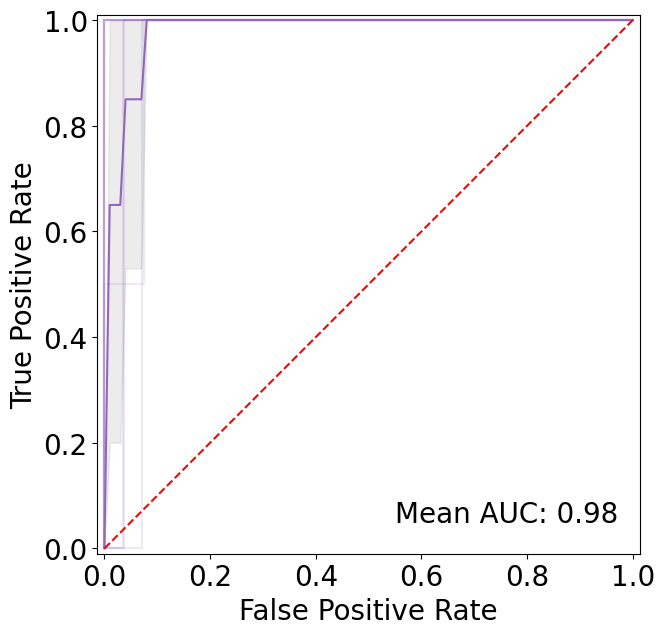

In [28]:
# Store AUCs and TPRs
aucs = []
tprs = []
base_fpr = np.linspace(0, 1, 101)

# Store accuracy, precision, recall and f1 scores
accuracies = []
precisions = []
recalls = []
f1s = []

# Initialize figure
plt.figure(figsize=(7, 7))
plt.axes().set_aspect('equal', 'datalim')

# Loop through cross-validation and plot ROC curves, calculate AUCs and TPRs and store scores
for i, (train, test) in enumerate(cv.split(X, y)):
    # Fit model to data
    mlp.fit(X[train], y[train])

    # Predict values
    y_score = mlp.predict_proba(X[test])
    y_pred = mlp.predict(X[test])

    # Determine metrics
    fpr, tpr, _ = roc_curve(y[test], y_score[:, 1])
    accuracies.append(accuracy_score(y[test], y_pred))
    precisions.append(precision_score(y[test], y_pred, zero_division=0))
    recalls.append(recall_score(y[test], y_pred, zero_division=0))
    f1s.append(f1_score(y[test], y_pred, zero_division=0))
    
    # Plot ROC curve
    plt.plot(fpr, tpr, 'tab:purple', alpha=0.15)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0

    # Store AUCs and TPRs
    tprs.append(tpr)
    aucs.append(roc_auc_score(y[test], y_score[:, 1]))

# Determine mean metrics
tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)
tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

mean_precision = np.mean(precisions)
std_precision = np.std(precisions)

mean_recall = np.mean(recalls)
std_recall = np.std(recalls)

mean_f1 = np.mean(f1s)
std_f1 = np.std(f1s)

# Plot mean ROC curve and save figure
plt.plot(base_fpr, mean_tprs, 'tab:purple')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.15)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.text(0.55, 0.05, f'Mean AUC: {round(np.mean(aucs), 2)}')
plt.savefig('plots/mlp.pdf')

# Print mean metrics
print(f'Mean accuracy: {round(mean_accuracy, 2)} ± {round(std_accuracy, 2)}')
print(f'Mean precision: {round(mean_precision, 2)} ± {round(std_precision, 2)}')
print(f'Mean recall: {round(mean_recall, 2)} ± {round(std_recall, 2)}')
print(f'Mean F1: {round(mean_f1, 2)} ± {round(std_f1, 2)}')

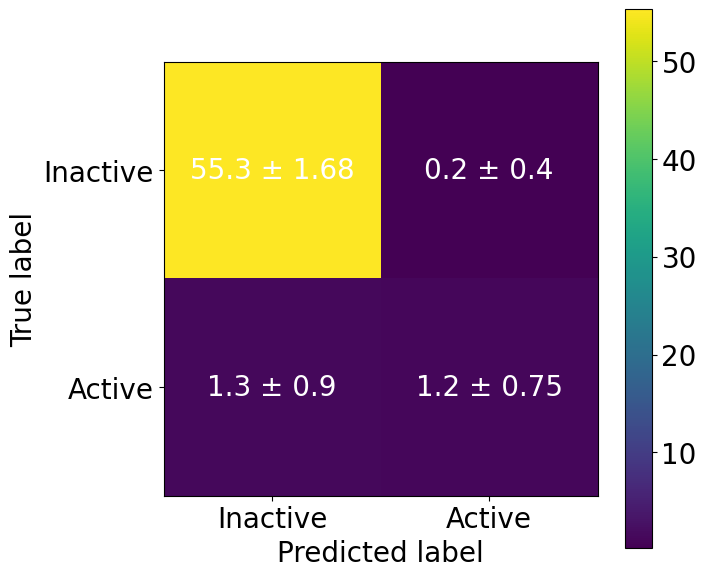

In [29]:
confusion_matrices = []
for i in range(0, 10):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

    # Fit model to data
    mlp.fit(X_train, y_train)

    # Predict values
    y_pred = mlp.predict(X_test)

    # Determine confusion matrix
    conf_mat = confusion_matrix(y_test, y_pred)

    # Store confusion matrix
    confusion_matrices.append(conf_mat)

# Determine mean confusion matrix
mean_confusion = np.round(np.mean(confusion_matrices, axis=0), decimals=2)
std_confusion = np.round(np.std(confusion_matrices, axis=0), decimals=2)

# Plot confusion matrix
plt.figure(figsize=(7, 7))
plt.axes().set_aspect('equal')
plt.imshow(mean_confusion, cmap='viridis')
for i in range(2):
    for j in range(2):
        plt.text(j, i, f'{mean_confusion[i, j]} ± {std_confusion[i, j]}', ha='center', va='center', color='w')
plt.colorbar()
plt.xticks([0, 1], ['Inactive', 'Active'])
plt.yticks([0, 1], ['Inactive', 'Active'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.savefig('plots/mlp_confusion_matrix.pdf', bbox_inches='tight')

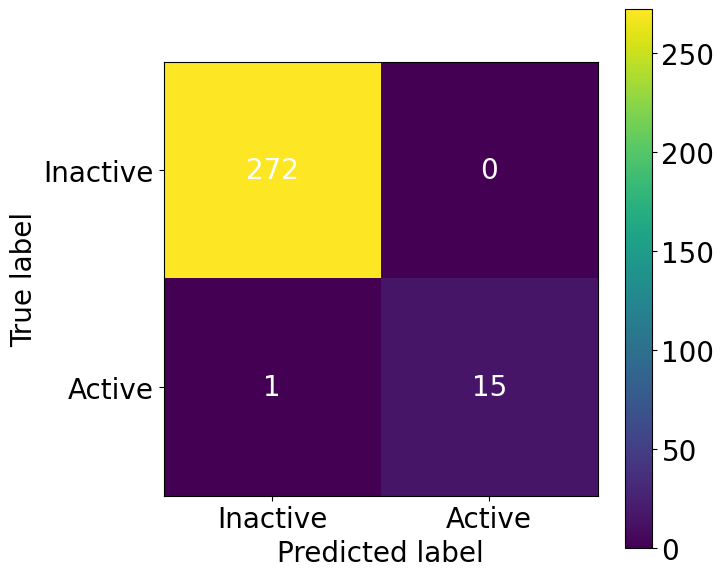

In [30]:
mlp.fit(X, y)

confusion_mat = confusion_matrix(y, mlp.predict(X))

plt.figure(figsize=(7, 7))
plt.axes().set_aspect('equal')
plt.imshow(confusion_mat, cmap='viridis')
for i in range(2):
    for j in range(2):
        plt.text(j, i, int(confusion_mat[i, j]), ha='center', va='center', color='w')
plt.colorbar()
plt.xticks([0, 1], ['Inactive', 'Active'])
plt.yticks([0, 1], ['Inactive', 'Active'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.savefig('plots/mlp_confusion_matrix_on_training.pdf', bbox_inches='tight')

#### K-Nearest Neighbors

In [31]:
knn = KNeighborsClassifier(n_neighbors=25, weights='distance')
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

Mean accuracy: 0.94 ± 0.02
Mean precision: 0.0 ± 0.0
Mean recall: 0.0 ± 0.0
Mean F1: 0.0 ± 0.0


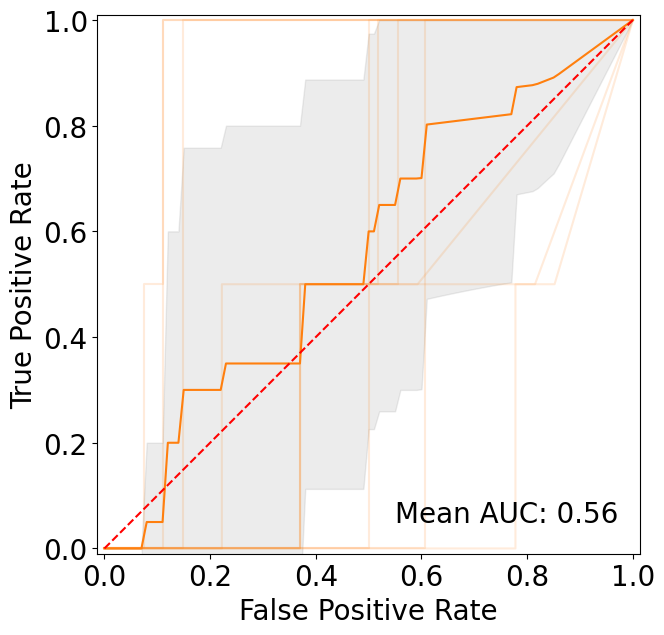

In [32]:
# Store AUCs and TPRs
aucs = []
tprs = []
base_fpr = np.linspace(0, 1, 101)

# Store accuracy, precision, recall and f1 scores
accuracies = []
precisions = []
recalls = []
f1s = []

# Initialize figure
plt.figure(figsize=(7, 7))
plt.axes().set_aspect('equal', 'datalim')

# Loop through cross-validation and plot ROC curves, calculate AUCs and TPRs and store scores
for i, (train, test) in enumerate(cv.split(X, y_scrambled)):
    # Fit model to data
    knn.fit(X[train], y_scrambled[train])

    # Predict values
    y_score = knn.predict_proba(X[test])
    y_pred = knn.predict(X[test])

    # Determine metrics
    fpr, tpr, _ = roc_curve(y_scrambled[test], y_score[:, 1])
    accuracies.append(accuracy_score(y_scrambled[test], y_pred))
    precisions.append(precision_score(y_scrambled[test], y_pred, zero_division=0))
    recalls.append(recall_score(y_scrambled[test], y_pred, zero_division=0))
    f1s.append(f1_score(y_scrambled[test], y_pred, zero_division=0))
    
    # Plot ROC curve
    plt.plot(fpr, tpr, 'tab:orange', alpha=0.15)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0

    # Store AUCs and TPRs
    tprs.append(tpr)
    aucs.append(roc_auc_score(y_scrambled[test], y_score[:, 1]))

# Determine mean metrics
tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)
tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

mean_precision = np.mean(precisions)
std_precision = np.std(precisions)

mean_recall = np.mean(recalls)
std_recall = np.std(recalls)

mean_f1 = np.mean(f1s)
std_f1 = np.std(f1s)

# Plot mean ROC curve and save figure
plt.plot(base_fpr, mean_tprs, 'tab:orange')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.15)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.text(0.55, 0.05, f'Mean AUC: {round(np.mean(aucs), 2)}')
plt.savefig('plots/knn_scrambled.pdf')

# Print mean metrics
print(f'Mean accuracy: {round(mean_accuracy, 2)} ± {round(std_accuracy, 2)}')
print(f'Mean precision: {round(mean_precision, 2)} ± {round(std_precision, 2)}')
print(f'Mean recall: {round(mean_recall, 2)} ± {round(std_recall, 2)}')
print(f'Mean F1: {round(mean_f1, 2)} ± {round(std_f1, 2)}')

Mean accuracy: 0.94 ± 0.02
Mean precision: 0.0 ± 0.0
Mean recall: 0.0 ± 0.0
Mean F1: 0.0 ± 0.0


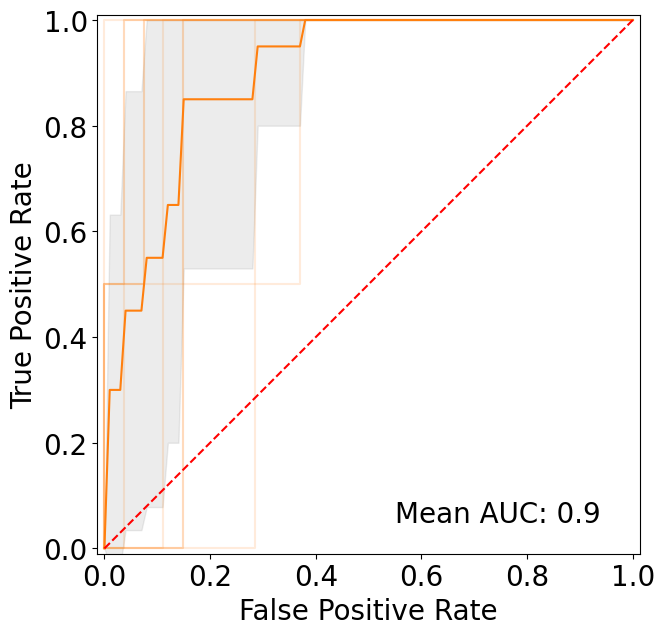

In [33]:
# Store AUCs and TPRs
aucs = []
tprs = []
base_fpr = np.linspace(0, 1, 101)

# Store accuracy, precision, recall and f1 scores
accuracies = []
precisions = []
recalls = []
f1s = []

# Initialize figure
plt.figure(figsize=(7, 7))
plt.axes().set_aspect('equal', 'datalim')

# Loop through cross-validation and plot ROC curves, calculate AUCs and TPRs and store scores
for i, (train, test) in enumerate(cv.split(X, y)):
    # Fit model to data
    knn.fit(X[train], y[train])

    # Predict values
    y_score = knn.predict_proba(X[test])
    y_pred = knn.predict(X[test])

    # Determine metrics
    fpr, tpr, _ = roc_curve(y[test], y_score[:, 1])
    accuracies.append(accuracy_score(y[test], y_pred))
    precisions.append(precision_score(y[test], y_pred, zero_division=0))
    recalls.append(recall_score(y[test], y_pred, zero_division=0))
    f1s.append(f1_score(y[test], y_pred, zero_division=0))
    
    # Plot ROC curve
    plt.plot(fpr, tpr, 'tab:orange', alpha=0.15)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0

    # Store AUCs and TPRs
    tprs.append(tpr)
    aucs.append(roc_auc_score(y[test], y_score[:, 1]))

# Determine mean metrics
tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)
tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

mean_precision = np.mean(precisions)
std_precision = np.std(precisions)

mean_recall = np.mean(recalls)
std_recall = np.std(recalls)

mean_f1 = np.mean(f1s)
std_f1 = np.std(f1s)

# Plot mean ROC curve and save figure
plt.plot(base_fpr, mean_tprs, 'tab:orange')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.15)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.text(0.55, 0.05, f'Mean AUC: {round(np.mean(aucs), 2)}')
plt.savefig('plots/knn.pdf')

# Print mean metrics
print(f'Mean accuracy: {round(mean_accuracy, 2)} ± {round(std_accuracy, 2)}')
print(f'Mean precision: {round(mean_precision, 2)} ± {round(std_precision, 2)}')
print(f'Mean recall: {round(mean_recall, 2)} ± {round(std_recall, 2)}')
print(f'Mean F1: {round(mean_f1, 2)} ± {round(std_f1, 2)}')

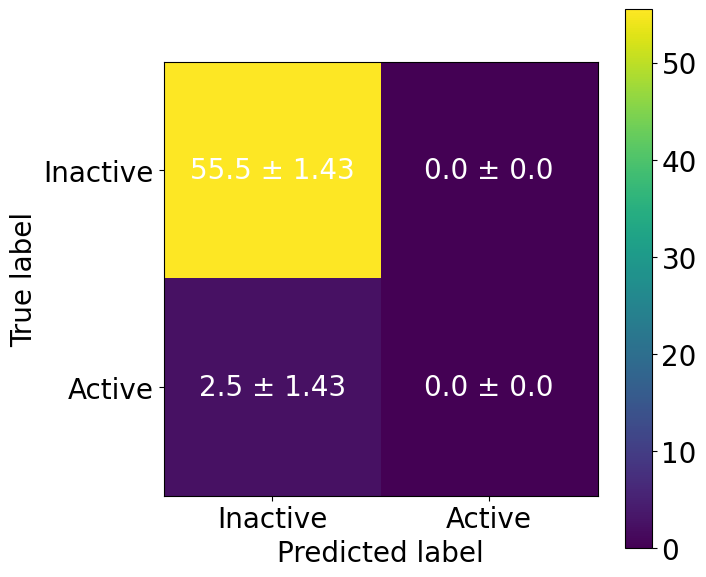

In [34]:
confusion_matrices = []
for i in range(0, 10):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

    # Fit model to data
    knn.fit(X_train, y_train)

    # Predict values
    y_pred = knn.predict(X_test)

    # Determine confusion matrix
    conf_mat = confusion_matrix(y_test, y_pred)

    # Store confusion matrix
    confusion_matrices.append(conf_mat)

# Determine mean confusion matrix
mean_confusion = np.round(np.mean(confusion_matrices, axis=0), decimals=2)
std_confusion = np.round(np.std(confusion_matrices, axis=0), decimals=2)

# Plot confusion matrix
plt.figure(figsize=(7, 7))
plt.axes().set_aspect('equal')
plt.imshow(mean_confusion, cmap='viridis')
for i in range(2):
    for j in range(2):
        plt.text(j, i, f'{mean_confusion[i, j]} ± {std_confusion[i, j]}', ha='center', va='center', color='w')
plt.colorbar()
plt.xticks([0, 1], ['Inactive', 'Active'])
plt.yticks([0, 1], ['Inactive', 'Active'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.savefig('plots/knn_confusion_matrix.pdf', bbox_inches='tight')

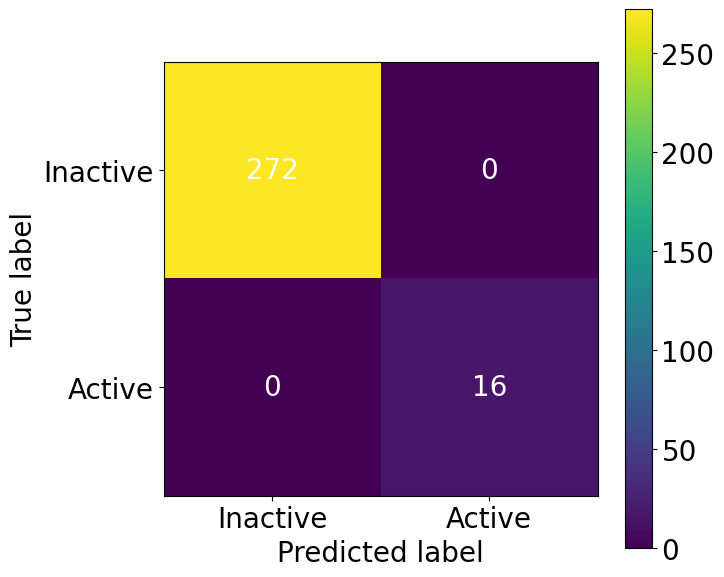

In [35]:
knn.fit(X, y)

confusion_mat = confusion_matrix(y, knn.predict(X))

plt.figure(figsize=(7, 7))
plt.axes().set_aspect('equal')
plt.imshow(confusion_mat, cmap='viridis')
for i in range(2):
    for j in range(2):
        plt.text(j, i, int(confusion_mat[i, j]), ha='center', va='center', color='w')
plt.colorbar()
plt.xticks([0, 1], ['Inactive', 'Active'])
plt.yticks([0, 1], ['Inactive', 'Active'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.savefig('plots/knn_confusion_matrix_on_training.pdf', bbox_inches='tight')

#### XGBoost

In [36]:
xgb = GradientBoostingClassifier(random_state=42)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

Mean accuracy: 0.92 ± 0.04
Mean precision: 0.05 ± 0.15
Mean recall: 0.05 ± 0.15
Mean F1: 0.05 ± 0.15


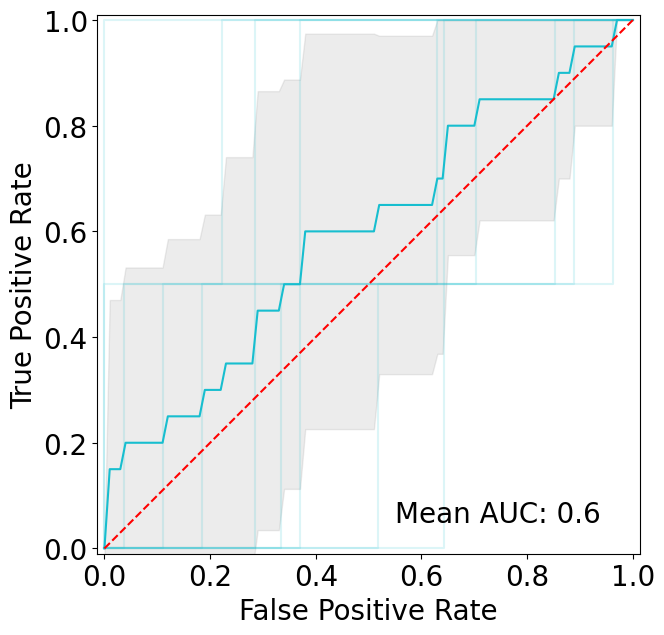

In [37]:
# Store AUCs and TPRs
aucs = []
tprs = []
base_fpr = np.linspace(0, 1, 101)

# Store accuracy, precision, recall and f1 scores
accuracies = []
precisions = []
recalls = []
f1s = []

# Initialize figure
plt.figure(figsize=(7, 7))
plt.axes().set_aspect('equal', 'datalim')

# Loop through cross-validation and plot ROC curves, calculate AUCs and TPRs and store scores
for i, (train, test) in enumerate(cv.split(X, y_scrambled)):
    # Fit model to data
    xgb.fit(X[train], y_scrambled[train])

    # Predict values
    y_score = xgb.predict_proba(X[test])
    y_pred = xgb.predict(X[test])

    # Determine metrics
    fpr, tpr, _ = roc_curve(y_scrambled[test], y_score[:, 1])
    accuracies.append(accuracy_score(y_scrambled[test], y_pred))
    precisions.append(precision_score(y_scrambled[test], y_pred, zero_division=0))
    recalls.append(recall_score(y_scrambled[test], y_pred, zero_division=0))
    f1s.append(f1_score(y_scrambled[test], y_pred, zero_division=0))
    
    # Plot ROC curve
    plt.plot(fpr, tpr, 'tab:cyan', alpha=0.15)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0

    # Store AUCs and TPRs
    tprs.append(tpr)
    aucs.append(roc_auc_score(y_scrambled[test], y_score[:, 1]))

# Determine mean metrics
tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)
tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

mean_precision = np.mean(precisions)
std_precision = np.std(precisions)

mean_recall = np.mean(recalls)
std_recall = np.std(recalls)

mean_f1 = np.mean(f1s)
std_f1 = np.std(f1s)

# Plot mean ROC curve and save figure
plt.plot(base_fpr, mean_tprs, 'tab:cyan')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.15)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.text(0.55, 0.05, f'Mean AUC: {round(np.mean(aucs), 2)}')
plt.savefig('plots/xgb_scrambled.pdf')

# Print mean metrics
print(f'Mean accuracy: {round(mean_accuracy, 2)} ± {round(std_accuracy, 2)}')
print(f'Mean precision: {round(mean_precision, 2)} ± {round(std_precision, 2)}')
print(f'Mean recall: {round(mean_recall, 2)} ± {round(std_recall, 2)}')
print(f'Mean F1: {round(mean_f1, 2)} ± {round(std_f1, 2)}')

Mean accuracy: 0.96 ± 0.01
Mean precision: 0.58 ± 0.42
Mean recall: 0.5 ± 0.39
Mean F1: 0.49 ± 0.33


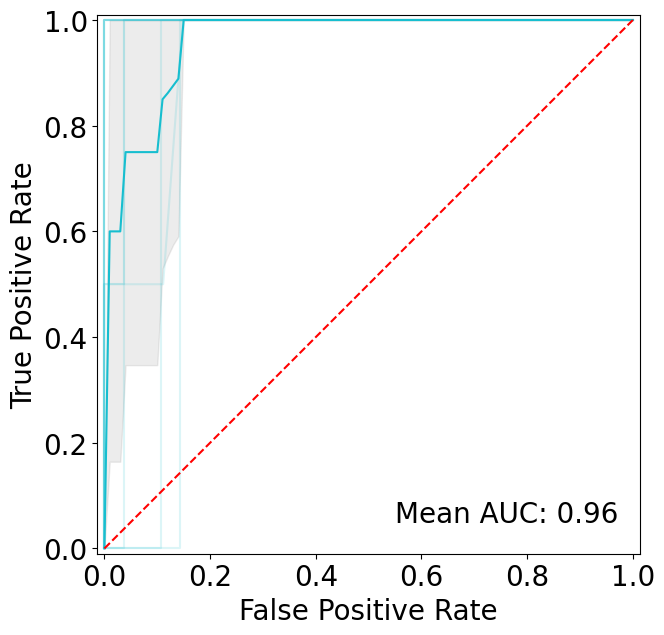

In [38]:
# Store AUCs and TPRs
aucs = []
tprs = []
base_fpr = np.linspace(0, 1, 101)

# Store accuracy, precision, recall and f1 scores
accuracies = []
precisions = []
recalls = []
f1s = []

# Initialize figure
plt.figure(figsize=(7, 7))
plt.axes().set_aspect('equal', 'datalim')

# Loop through cross-validation and plot ROC curves, calculate AUCs and TPRs and store scores
for i, (train, test) in enumerate(cv.split(X, y)):
    # Fit model to data
    xgb.fit(X[train], y[train])

    # Predict values
    y_score = xgb.predict_proba(X[test])
    y_pred = xgb.predict(X[test])

    # Determine metrics
    fpr, tpr, _ = roc_curve(y[test], y_score[:, 1])
    accuracies.append(accuracy_score(y[test], y_pred))
    precisions.append(precision_score(y[test], y_pred, zero_division=0))
    recalls.append(recall_score(y[test], y_pred, zero_division=0))
    f1s.append(f1_score(y[test], y_pred, zero_division=0))
    
    # Plot ROC curve
    plt.plot(fpr, tpr, 'tab:cyan', alpha=0.15)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0

    # Store AUCs and TPRs
    tprs.append(tpr)
    aucs.append(roc_auc_score(y[test], y_score[:, 1]))

# Determine mean metrics
tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)
tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

mean_precision = np.mean(precisions)
std_precision = np.std(precisions)

mean_recall = np.mean(recalls)
std_recall = np.std(recalls)

mean_f1 = np.mean(f1s)
std_f1 = np.std(f1s)

# Plot mean ROC curve and save figure
plt.plot(base_fpr, mean_tprs, 'tab:cyan')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.15)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.text(0.55, 0.05, f'Mean AUC: {round(np.mean(aucs), 2)}')
plt.savefig('plots/xgb.pdf')

# Print mean metrics
print(f'Mean accuracy: {round(mean_accuracy, 2)} ± {round(std_accuracy, 2)}')
print(f'Mean precision: {round(mean_precision, 2)} ± {round(std_precision, 2)}')
print(f'Mean recall: {round(mean_recall, 2)} ± {round(std_recall, 2)}')
print(f'Mean F1: {round(mean_f1, 2)} ± {round(std_f1, 2)}')

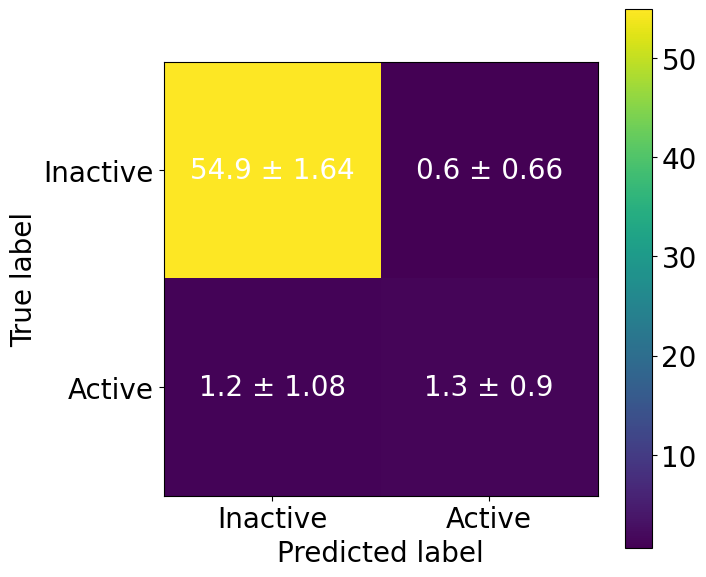

In [39]:
confusion_matrices = []
for i in range(0, 10):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

    # Fit model to data
    xgb.fit(X_train, y_train)

    # Predict values
    y_pred = xgb.predict(X_test)

    # Determine confusion matrix
    conf_mat = confusion_matrix(y_test, y_pred)

    # Store confusion matrix
    confusion_matrices.append(conf_mat)

# Determine mean confusion matrix
mean_confusion = np.round(np.mean(confusion_matrices, axis=0), decimals=2)
std_confusion = np.round(np.std(confusion_matrices, axis=0), decimals=2)

# Plot confusion matrix
plt.figure(figsize=(7, 7))
plt.axes().set_aspect('equal')
plt.imshow(mean_confusion, cmap='viridis')
for i in range(2):
    for j in range(2):
        plt.text(j, i, f'{mean_confusion[i, j]} ± {std_confusion[i, j]}', ha='center', va='center', color='w')
plt.colorbar()
plt.xticks([0, 1], ['Inactive', 'Active'])
plt.yticks([0, 1], ['Inactive', 'Active'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.savefig('plots/xgb_confusion_matrix.pdf', bbox_inches='tight')

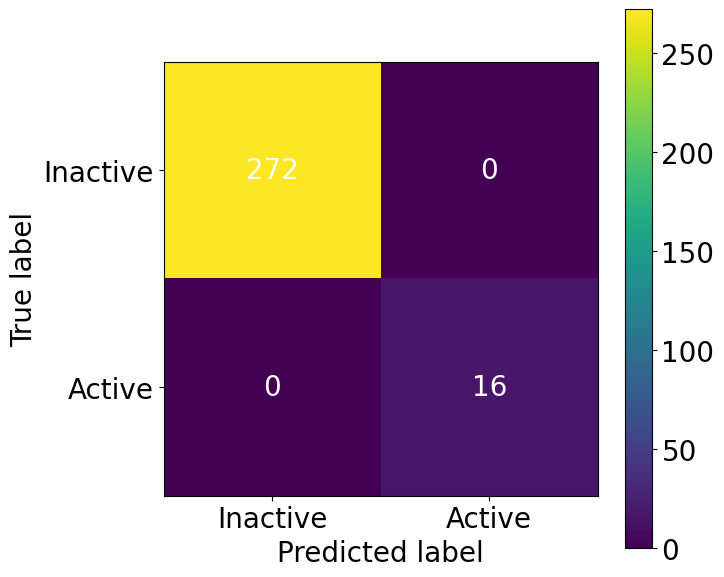

In [40]:
xgb.fit(X, y)

confusion_mat = confusion_matrix(y, xgb.predict(X))

plt.figure(figsize=(7, 7))
plt.axes().set_aspect('equal')
plt.imshow(confusion_mat, cmap='viridis')
for i in range(2):
    for j in range(2):
        plt.text(j, i, int(confusion_mat[i, j]), ha='center', va='center', color='w')
plt.colorbar()
plt.xticks([0, 1], ['Inactive', 'Active'])
plt.yticks([0, 1], ['Inactive', 'Active'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.savefig('plots/xgb_confusion_matrix_on_training.pdf', bbox_inches='tight')

#### Generate library


Fit and store models

In [43]:
rf.fit(X, y)
dump(rf, 'models/rf.joblib')

nb.fit(X, y)
dump(nb, 'models/nb.joblib')

svm.fit(X, y)
dump(svm, 'models/svm.joblib')

mlp.fit(X, y)
dump(mlp, 'models/mlp.joblib')

knn.fit(X, y)
dump(knn, 'models/knn.joblib')

xgb.fit(X, y)
dump(xgb, 'models/xgb.joblib')

['models/xgb.joblib']

The library contains combinatorially generated compounds predicted to be active by a predictive model

In [ ]:
for i in range(len(library_arenes)):
    for j in tqdm(range(len(library_amines))):
        with open('data/libraries/svm_library.csv', 'a') as f: #change directory and name of the generated library in this line
            for k in range(len(library_aldehydes)):
                if svm.predict(np.sum([library_arenes.ECFP4.iloc[i], library_amines.ECFP4.iloc[j], library_aldehydes.ECFP4.iloc[k]], axis=0).reshape(1, -1)) == 1: #change prediction model in this line
                    f.write(f'{library_arenes.ID.iloc[i]}{library_amines.ID.iloc[j]}{library_aldehydes.ID.iloc[k]},{library_arenes.SMILES.iloc[i]}.{library_amines.SMILES.iloc[j]}.{library_aldehydes.SMILES.iloc[k]}')
                    f.write('\n')
                else:
                    continue